# Chocolate Bar Analysis - Predicting Numeric Ratings with Random Forest and Decision Tree Regressors

In [1]:
# Import Libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.tree import DecisionTreeRegressor, plot_tree


In [2]:
# Import data and display first rows
df_raw = pd.read_csv('C:/Users/nickm/Desktop/Coding/Projects/chocolate-bar-analysis/Chocolate bar ratings 2022 - RECODE.csv')
df_raw.head()

,REF,Company (Manufacturer),Company Location,Review Date,Country of Bean Origin,Specific Bean Origin or Bar Name,Cocoa Percent,Ingredients,Most Memorable Characteristics,Rating,...,Characteristic - sour,Characteristic - spicy,Characteristic - molasses,Characteristic - woody,Characteristic - fruit,Characteristic - vanilla,Characteristic - sticky,Characteristic - dried fruit,Characteristic - coffee,Characteristic - rich
0,2454,5150,U.S.A.,2019,Tanzania,"Kokoa Kamili, batch 1",76%,"3- B,S,C","rich cocoa, fatty, bready",3.25,...,False,False,False,False,False,False,False,False,False,True
1,2454,5150,U.S.A.,2019,Madagascar,"Bejofo Estate, batch 1",76%,"3- B,S,C","cocoa, blackberry, full body",3.75,...,False,False,False,False,False,False,False,False,False,False
2,2458,5150,U.S.A.,2019,Dominican Republic,"Zorzal, batch 1",76%,"3- B,S,C","cocoa, vegetal, savory",3.50,...,False,False,False,False,False,False,False,False,False,False
3,2542,5150,U.S.A.,2021,Fiji,"Matasawalevu, batch 1",68%,"3- B,S,C","chewy, off, rubbery",3.00,...,False,False,False,False,False,False,False,False,False,False
4,2542,5150,U.S.A.,2021,India,"Anamalai, batch 1",68%,"3- B,S,C","milk brownie, macadamia,chewy",3.50,...,False,False,False,False,False,False,False,False,False,False


In [3]:
# Create y and X dfs with test and training data
y = df_raw['Rating'].copy()
print(y.value_counts().head())

x_vars = ['Number of Ingredients',
          'Cocoa Percent - Numerical', 
          *list(df_raw.filter(regex='Ingredient ')),
          *list(df_raw.filter(regex='Characteristic '))]

X = df_raw[x_vars]
print(X.columns[:10])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for dfs, df_name in zip([X_train, X_test, y_train, y_test], ['X_train', 'X_test', 'y_train', 'y_test']):
    print(f'{df_name} shape:', dfs.shape)


Rating
3.50    571
3.00    517
3.25    463
2.75    326
3.75    301
Name: count, dtype: int64
Index(['Number of Ingredients', 'Cocoa Percent - Numerical', 'Ingredient B',
       'Ingredient S', 'Ingredient S*', 'Ingredient C', 'Ingredient V',
       'Ingredient L', 'Ingredient Sa', 'Characteristic - sweet'],
      dtype='object')
X_train shape: (2000, 29)
X_test shape: (501, 29)
y_train shape: (2000,)
y_test shape: (501,)


## Random Forest

### Random Forest with default parameters

Mean Absolute Error (MAE): 0.299
Mean Squared Error (MSE): 0.154
Root Mean Squared Error (RMSE): 0.393
Mean Absolute Percentage Error (MAPE): 0.097
Explained Variance Score: 0.0925
Accuracy: 90.25 %
R^2: 0.0914


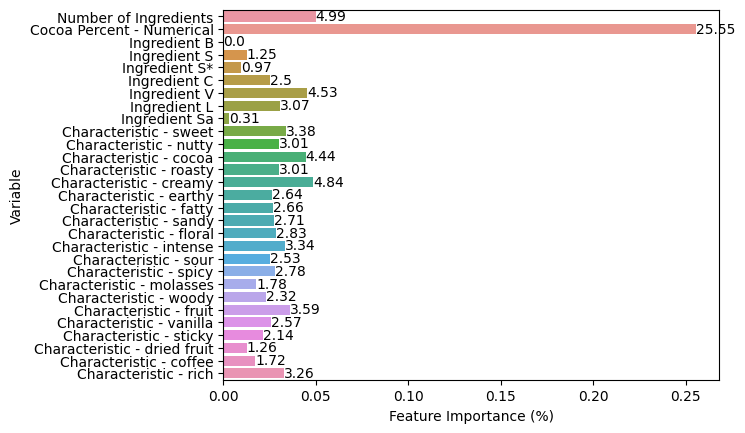

In [15]:
rfr = RandomForestRegressor(random_state=42)

rfr_model = rfr.fit(X_train, y_train)

# Accuracy Metrics
y_pred_X_test = rfr_model.predict(X_test)

print('Mean Absolute Error (MAE):', round(metrics.mean_absolute_error(y_test, y_pred_X_test), 3))
print('Mean Squared Error (MSE):', round(metrics.mean_squared_error(y_test, y_pred_X_test), 3))
print('Root Mean Squared Error (RMSE):', round(metrics.mean_squared_error(y_test, y_pred_X_test, squared=False), 3))
print('Mean Absolute Percentage Error (MAPE):', round(metrics.mean_absolute_percentage_error(y_test, y_pred_X_test), 3))
print('Explained Variance Score:', round(metrics.explained_variance_score(y_test, y_pred_X_test), 4))
print('Accuracy:', round(100*(1 - metrics.mean_absolute_percentage_error(y_test, y_pred_X_test)), 2), '%')
print('R^2:', round(metrics.r2_score(y_test, y_pred_X_test), 4))

# Feature Importance
rfr_imp = pd.DataFrame({
    'Variable': x_vars,
    'Feature Importance (%)': rfr.feature_importances_
})

fig, ax = plt.subplots()
sns.barplot(y=rfr_imp['Variable'], x=rfr_imp['Feature Importance (%)'])
ax.bar_label(ax.containers[0], labels=round(rfr_imp['Feature Importance (%)']*100, 2));


### Random Forest with Hyper Parameter Tuning

#### Search on hyper parameters

In [23]:
np.random.seed(42)

param = {
    'n_estimators': list(range(100, 1001, 100)),
    'max_depth': [None] + list(range(3, 20)),
    'max_features': ['sqrt', 'log2', None] + list(np.linspace(0.5,1,5)),
    'max_leaf_nodes': [None] + list(range(10, 501, 10)),
    'bootstrap': [True, False]
    }

rs = RandomizedSearchCV(rfr, param, cv=5, scoring='r2', verbose=0, n_jobs=-1)
rs.fit(X_train, y_train)
print('\nRandomizedSearchCV result:\nBest Score:', rs.best_score_, '\nBest parameters:', rs.best_params_)


RandomizedSearchCV result:
Best Score: 0.1852092418535582 
Best parameters: {'n_estimators': 900, 'max_leaf_nodes': 100, 'max_features': 'sqrt', 'max_depth': 11, 'bootstrap': False}


#### RF with best hyper parameters

Mean Absolute Error (MAE): 0.29
Mean Squared Error (MSE): 0.131
Root Mean Squared Error (RMSE): 0.362
Mean Absolute Percentage Error (MAPE): 0.095
Explained Variance Score: 0.2284
Accuracy: 90.5 %
R^2: 0.2279


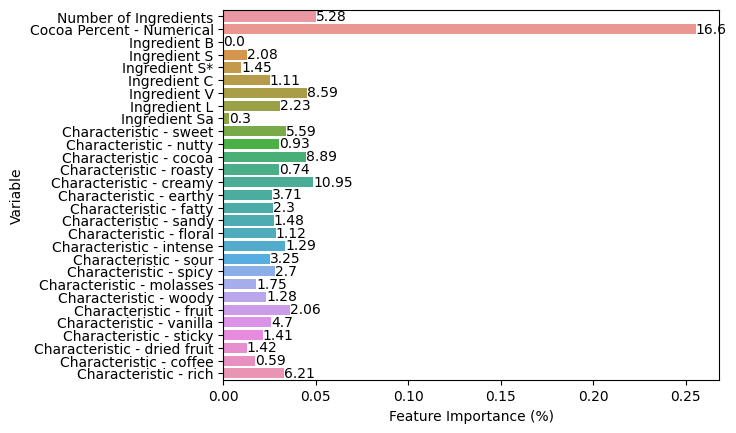

In [14]:
np.random.seed(42)

rfr_hype = RandomForestRegressor(random_state = 42,
                                  n_estimators = 900,
                                  max_leaf_nodes = 100,
                                  max_features = 'sqrt',
                                  max_depth = 11,
                                  bootstrap = False)

rfr_hype_model = rfr_hype.fit(X_train, y_train)

# Accuracy Metrics
rfr_hype_y_pred_X_test = rfr_hype_model.predict(X_test)

print('Mean Absolute Error (MAE):', round(metrics.mean_absolute_error(y_test, rfr_hype_y_pred_X_test), 3))
print('Mean Squared Error (MSE):', round(metrics.mean_squared_error(y_test, rfr_hype_y_pred_X_test), 3))
print('Root Mean Squared Error (RMSE):', round(metrics.mean_squared_error(y_test, rfr_hype_y_pred_X_test, squared=False), 3))
print('Mean Absolute Percentage Error (MAPE):', round(metrics.mean_absolute_percentage_error(y_test, rfr_hype_y_pred_X_test), 3))
print('Explained Variance Score:', round(metrics.explained_variance_score(y_test, rfr_hype_y_pred_X_test), 4))
print('Accuracy:', round(100*(1 - metrics.mean_absolute_percentage_error(y_test, rfr_hype_y_pred_X_test)), 2), '%')
print('R^2:', round(metrics.r2_score(y_test, rfr_hype_y_pred_X_test), 4))

# Feature Importance
rfr_hype_imp = pd.DataFrame({
    'Variable': x_vars,
    'Feature Importance (%)': rfr_hype.feature_importances_
})

fig, ax = plt.subplots()
sns.barplot(y=rfr_hype_imp['Variable'], x=rfr_imp['Feature Importance (%)'])
ax.bar_label(ax.containers[0], labels=round(rfr_hype_imp['Feature Importance (%)']*100, 2));


## Decision Tree

Decision Tree with default paramaters

Mean Absolute Error (MAE): 0.353
Mean Squared Error (MSE): 0.219
Root Mean Squared Error (RMSE): 0.468
Mean Absolute Percentage Error (MAPE): 0.115
Explained Variance Score: -0.2887
Accuracy: 88.48 %
R^2: -0.2902
                    Variable  Feature Importance (%)
0      Number of Ingredients                0.037126
1  Cocoa Percent - Numerical                0.255238
2               Ingredient B                0.000000
3               Ingredient S                0.014335
4              Ingredient S*                0.002357


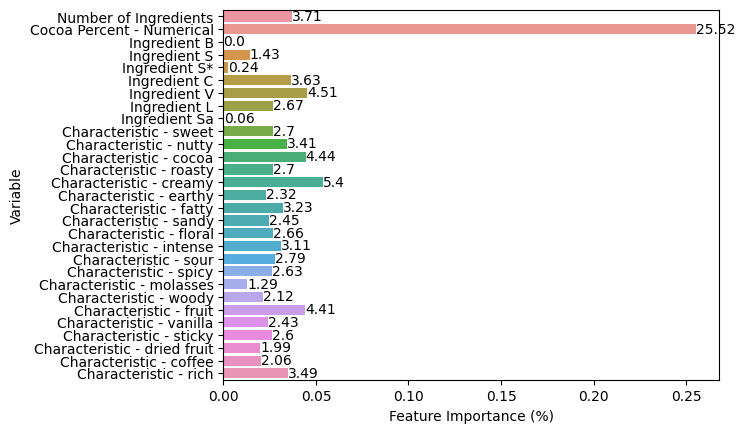

In [32]:
np.random.seed(42)

#dtr = DecisionTreeRegressor(max_depth=8, min_samples_leaf=100, random_state=42)
dtr = DecisionTreeRegressor(random_state=42)

dtr_model = dtr.fit(X_train, y_train)

# Accuracy Metrics
dtr_y_pred_X_test = dtr_model.predict(X_test)

print('Mean Absolute Error (MAE):', round(metrics.mean_absolute_error(y_test, dtr_y_pred_X_test), 3))
print('Mean Squared Error (MSE):', round(metrics.mean_squared_error(y_test, dtr_y_pred_X_test), 3))
print('Root Mean Squared Error (RMSE):', round(metrics.mean_squared_error(y_test, dtr_y_pred_X_test, squared=False), 3))
print('Mean Absolute Percentage Error (MAPE):', round(metrics.mean_absolute_percentage_error(y_test, dtr_y_pred_X_test), 3))
print('Explained Variance Score:', round(metrics.explained_variance_score(y_test, dtr_y_pred_X_test), 4))
print('Accuracy:', round(100*(1 - metrics.mean_absolute_percentage_error(y_test, dtr_y_pred_X_test)), 2), '%')
print('R^2:', round(metrics.r2_score(y_test, dtr_y_pred_X_test), 4))
#print('R^2:', round(dtr_model.score(X_test, y_test), 4))

# Feature importance
dtr_imp = pd.DataFrame({
    'Variable': x_vars,
    'Feature Importance (%)': dtr.feature_importances_
})
print(dtr_imp.head())

# Plots
fig, ax = plt.subplots()
sns.barplot(y=dtr_imp['Variable'], x=dtr_imp['Feature Importance (%)'])
ax.bar_label(ax.containers[0], labels=round(dtr_imp['Feature Importance (%)']*100, 2));

#fig, ax = plt.subplots()
#plot_tree(dtr, feature_names=x_vars);


### Decision Tree with Hyper Parameter Tuning

#### Search on hyper parameters

In [31]:
np.random.seed(42)

dt_param = {
    'max_depth': [None] + list(range(2, 20)),
    'min_samples_split': [None] + list(range(2, 20)),
    'min_samples_leaf': list(range(2, 20)),
    "max_features": [None, "auto", "log2", "sqrt"],
    "max_leaf_nodes":[None] + list(range(10,101,10))
    }

dt_rs = RandomizedSearchCV(dtr, dt_param, cv=5, scoring='r2', verbose=0, n_jobs=-1, error_score='raise')
dt_rs.fit(X_train, y_train)
print('\nRandomizedSearchCV result:\nBest Score:', dt_rs.best_score_, '\nBest parameters:', dt_rs.best_params_)


RandomizedSearchCV result:
Best Score: 0.11998013319050597 
Best parameters: {'min_samples_split': 17, 'min_samples_leaf': 12, 'max_leaf_nodes': 40, 'max_features': None, 'max_depth': 9}


#### Decision Tree with best hyper parameters

Mean Absolute Error (MAE): 0.302
Mean Squared Error (MSE): 0.142
Root Mean Squared Error (RMSE): 0.377
Mean Absolute Percentage Error (MAPE): 0.099
Explained Variance Score: 0.1646
Accuracy: 90.07 %
R^2: 0.1621
                    Variable  Feature Importance (%)
0      Number of Ingredients                0.010985
1  Cocoa Percent - Numerical                0.212328
2               Ingredient B                0.000000
3               Ingredient S                0.045770
4              Ingredient S*                0.000000


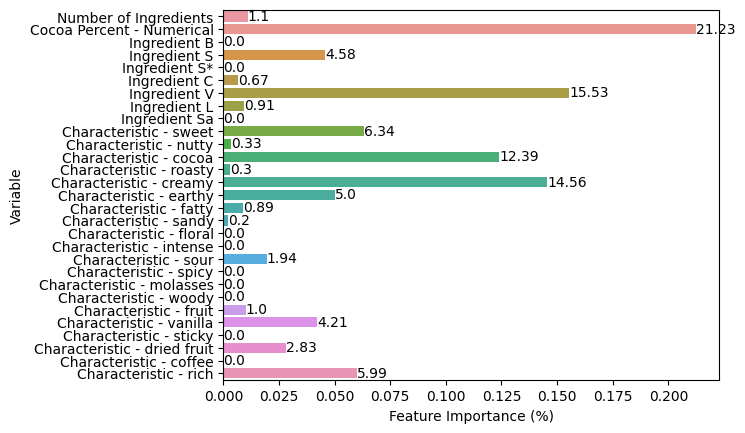

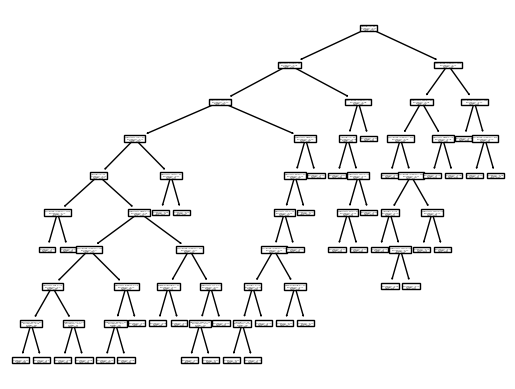

In [34]:
np.random.seed(42)

dtr_hype = DecisionTreeRegressor(random_state=42,
                                 min_samples_split = 17,
                                 min_samples_leaf = 12,
                                 max_leaf_nodes = 40,
                                 max_features = None,
                                 max_depth = 9)

dtr_hype_model = dtr_hype.fit(X_train, y_train)

# Accuracy Metrics
dtr_hype_y_pred_X_test = dtr_hype_model.predict(X_test)

print('Mean Absolute Error (MAE):', round(metrics.mean_absolute_error(y_test, dtr_hype_y_pred_X_test), 3))
print('Mean Squared Error (MSE):', round(metrics.mean_squared_error(y_test, dtr_hype_y_pred_X_test), 3))
print('Root Mean Squared Error (RMSE):', round(metrics.mean_squared_error(y_test, dtr_hype_y_pred_X_test, squared=False), 3))
print('Mean Absolute Percentage Error (MAPE):', round(metrics.mean_absolute_percentage_error(y_test, dtr_hype_y_pred_X_test), 3))
print('Explained Variance Score:', round(metrics.explained_variance_score(y_test, dtr_hype_y_pred_X_test), 4))
print('Accuracy:', round(100*(1 - metrics.mean_absolute_percentage_error(y_test, dtr_hype_y_pred_X_test)), 2), '%')
print('R^2:', round(metrics.r2_score(y_test, dtr_hype_y_pred_X_test), 4))
#print('R^2:', round(dtr_hype_model.score(X_test, y_test), 4))

# Feature importance
dtr_hype_imp = pd.DataFrame({
    'Variable': x_vars,
    'Feature Importance (%)': dtr_hype.feature_importances_
})
print(dtr_hype_imp.head())

# Plots
fig, ax = plt.subplots()
sns.barplot(y=dtr_hype_imp['Variable'], x=dtr_hype_imp['Feature Importance (%)'])
ax.bar_label(ax.containers[0], labels=round(dtr_hype_imp['Feature Importance (%)']*100, 2));

fig, ax = plt.subplots()
plot_tree(dtr_hype, feature_names=x_vars);


## Comparison of RF and DT Feature Importance

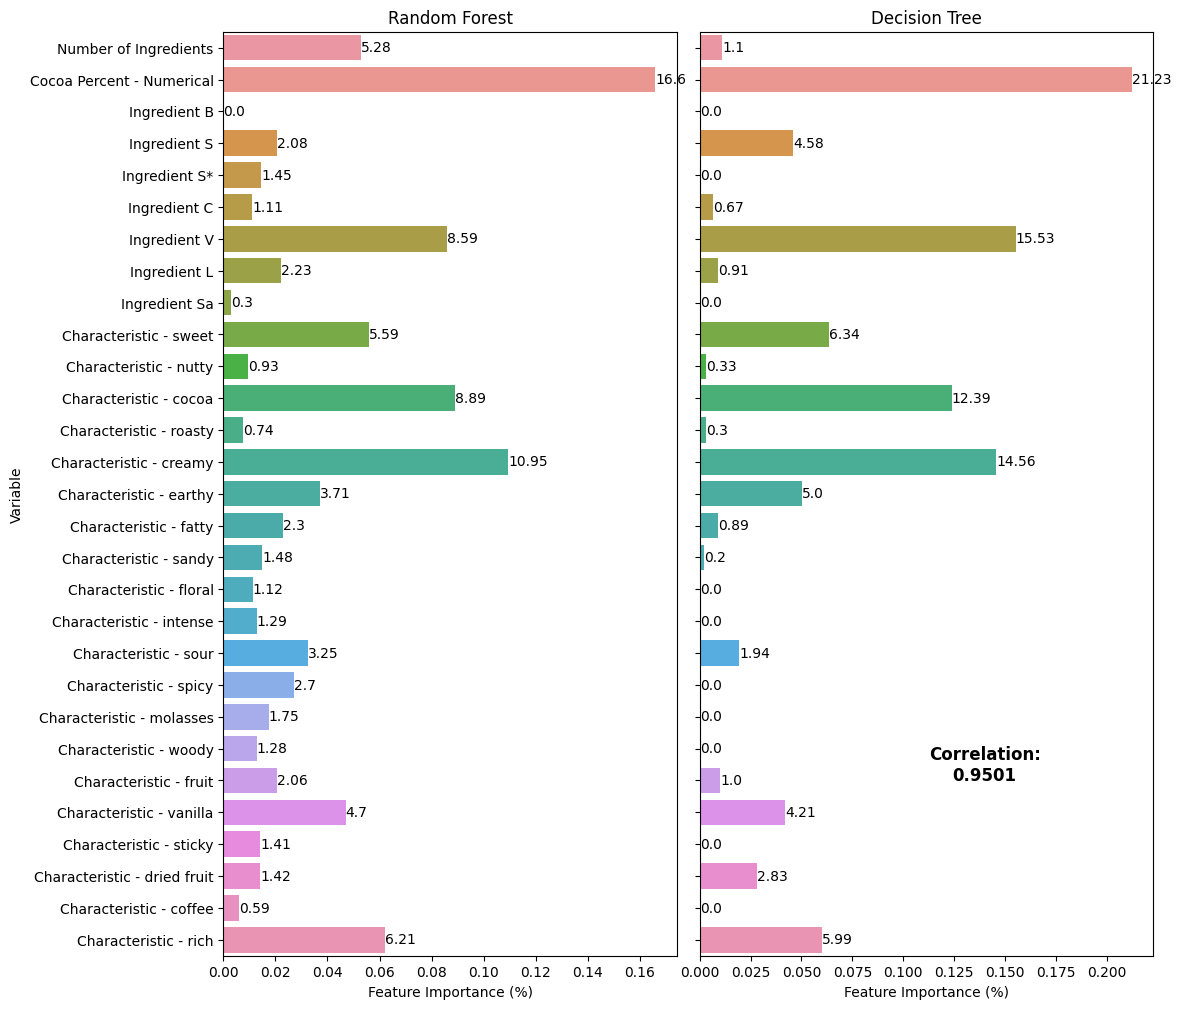

In [78]:
# Correlation
cor_txt = 'Correlation:\n' + str(round(rfr_hype_imp['Feature Importance (%)'].corr(dtr_hype_imp['Feature Importance (%)']), 4))

# Plots
fig, axs = plt.subplots(figsize=(12, 12), ncols=2)
plt.subplots_adjust(wspace=0.05)
plt.text(0.14, 23, cor_txt, size='large', weight='bold', horizontalalignment='center')

# Random Forest
rf_plot = sns.barplot(y=rfr_hype_imp['Variable'], x=rfr_hype_imp['Feature Importance (%)'], ax=axs[0])
rf_plot.set(title = 'Random Forest')
axs[0].bar_label(axs[0].containers[0], labels=round(rfr_hype_imp['Feature Importance (%)']*100, 2))

# Decision Tree
dt_plot = sns.barplot(y=dtr_hype_imp['Variable'], x=dtr_hype_imp['Feature Importance (%)'], ax=axs[1])
dt_plot.set(title='Decision Tree')
dt_plot.set(ylabel=None)
dt_plot.set(yticklabels=[])
axs[1].bar_label(axs[1].containers[0], labels=round(dtr_hype_imp['Feature Importance (%)']*100, 2));